In [29]:
#
# Created on Fri Nov 24 2023 00:57:09
# Author: Mukai (Tom Notch) Yu
# Email: myual@connect.ust.hk
# Affiliation: Hong Kong University of Science and Technology
#
# Copyright Ⓒ 2023 Mukai (Tom Notch) Yu
#
import torch
from matplotlib import pyplot as plt

from utils.files import read_file, print_dict
from dataloader.feature_extractor import FeatureExtractor
from dataloader.perspective_warper import PerspectiveWarper
from dataloader.general import FeatureMatchingDataLoader
from dataloader.visualization import visualize_matches

In [30]:
config = read_file("./configs/default.yaml")
print_dict(config)

mode: train
train: 
  num_epochs: 100.0
  learning_rate: 0.0001
  output_dir: ./dump_match_pairs/ # Path to the directory in which the .npz results and optional, visualizations are written during training
  dataset: 
    batch_size: 6.0
    shuffle: False
    COCO: 
      path: ./COCO2014/train2014
      fraction: 0.01
      resize: [640.0, 480.0]
      fix_warp: False
eval: 
  input_dir: ./assets/scannet_sample_images/ # Path to the directory that contains the images
  output_dir: ./dump_match_pairs/
  input_pairs: ./assets/scannet_sample_pairs_with_gt.txt # Path to the list of image pairs for evaluation
  eval_interval: 5.0
  dataset: 
    batch_size: 32.0
    shuffle: False
    COCO: 
      path: ./COCO2014/eval2014
      fraction: 0.01
      resize: [640.0, 480.0]
      fix_warp: True
feature_extraction: 
  max_keypoints: 48.0
  descriptor_dim: 256.0
  extractor: SIFT
  SIFT: 
    contrast_threshold: 0.0001
    edge_threshold: 10.0
    sigma: 1.6
  Superpoint: 
    keypoint_thresho

In [31]:
feature_extractor = FeatureExtractor(config["feature_extraction"])
perspective_warper = PerspectiveWarper(config["perspective_warper"])

dataloader = FeatureMatchingDataLoader(
    config["train"]["dataset"], feature_extractor, perspective_warper
)

In [32]:
batch = next(iter(dataloader))

number of ground truth match pairs: 11
dict_keys(['image0', 'image1', 'image0_shape', 'image1_shape', 'keypoints0', 'keypoints1', 'descriptors0', 'descriptors1', 'scores0', 'scores1', 'partial_assignment_matrix'])
torch.Size([6, 48, 2])
torch.Size([6, 48])
torch.Size([6, 49, 49])


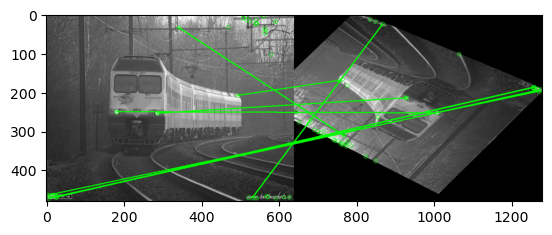

In [33]:
partial_assignment_matrix = batch["partial_assignment_matrix"]
print(
    "number of ground truth match pairs:",
    int(torch.sum(partial_assignment_matrix[0][:-1, :-1])),
)
print(batch.keys())
print(batch["keypoints0"].shape)
print(batch["scores0"].shape)
print(batch["partial_assignment_matrix"].shape)

plt.imshow(
    visualize_matches(
        batch["image0"][0],
        batch["image1"][0],
        batch["keypoints0"][0],
        batch["keypoints1"][0],
        batch["partial_assignment_matrix"][0],
    )
)